In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, average_precision_score, balanced_accuracy_score
)
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42


In [3]:
# Utility functions
def optimal_threshold(y_true, y_proba, target='f1', steps=200):
    thresholds = np.linspace(0, 1, steps+1)[1:-1]  # exclude 0 and 1
    if target == 'f1':
        best, best_t = -1, 0.5
        for t in thresholds:
            y_p = (y_proba >= t).astype(int)
            f1 = f1_score(y_true, y_p, zero_division=0)
            if f1 > best:
                best, best_t = f1, t
        return best_t
    elif target == 'youden':
        fpr, tpr, thr = roc_curve(y_true, y_proba)
        j = tpr - fpr
        idx = np.argmax(j)
        return thr[idx]
    else:
        raise ValueError("Unknown target. Use 'f1' or 'youden'.")

def plot_confusion(cm, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [4]:
#  Load the dataset with error handling

try:
    df = pd.read_csv('credit_scoring_sample.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'credit_scoring_sample.csv' not found. Please ensure the file is in the working directory.")
    raise SystemExit(1)
except pd.errors.EmptyDataError:
    print("Error: The dataset is empty.")
    raise SystemExit(1)

# Verify required columns
required_columns = [
    'SeriousDlqin2yrs', 'age', 'MonthlyIncome', 'DebtRatio',
    'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'
]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Error: Missing columns in dataset: {missing_columns}")
    raise SystemExit(1)


Dataset loaded successfully.


In [5]:
# Preprocessing and feature engineering
# Target NaNs
if df['SeriousDlqin2yrs'].isna().any():
    print("Warning: NaN values in target variable 'SeriousDlqin2yrs'. Dropping affected rows.")
    df = df.dropna(subset=['SeriousDlqin2yrs'])

print("\nNaN counts before preprocessing:")
print(df[required_columns].isna().sum())

# Handle missing values for key columns
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

# Fix DebtRatio (avoid division by zero)
def fix_debt_ratio(row):
    dr = row['DebtRatio']
    inc = row['MonthlyIncome']
    if pd.notna(dr) and pd.notna(inc) and dr > 1 and inc > 0:
        return dr / inc
    return dr

df['DebtRatio'] = df.apply(fix_debt_ratio, axis=1)
df['DebtRatio'] = df['DebtRatio'].fillna(df['DebtRatio'].median())

# Cap anomalous late payment counts
for col in ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']:
    df[col] = df[col].clip(upper=10)

# Feature engineering
df['Log_Income'] = np.log1p(df['MonthlyIncome'].clip(lower=0))
df['Total_Late_Payments'] = (
    df['NumberOfTime30-59DaysPastDueNotWorse'] +
    df['NumberOfTimes90DaysLate'] +
    df['NumberOfTime60-89DaysPastDueNotWorse']
)

# Robust numeric binning for Debt_to_Income_Bin
try:
    df['Debt_to_Income_Bin'] = pd.qcut(df['DebtRatio'], q=4, labels=False, duplicates='drop')
except ValueError as e:
    print(f"Error in pd.qcut: {e}. Using equally spaced bins as fallback.")
    df['Debt_to_Income_Bin'] = pd.cut(df['DebtRatio'], bins=4, labels=False, include_lowest=True)

df['Debt_to_Income_Bin'] = (
    pd.to_numeric(df['Debt_to_Income_Bin'], errors='coerce')
      .fillna(df['Debt_to_Income_Bin'].median())
      .astype(int)
)

df['Has_Dependents'] = (df['NumberOfDependents'] > 0).astype(int)

print("\nNaN counts after feature engineering:")
print(df[['Log_Income', 'DebtRatio', 'Total_Late_Payments', 'Debt_to_Income_Bin', 'Has_Dependents']].isna().sum())

# Select features and target
features = [
    'age', 'Log_Income', 'DebtRatio', 'Total_Late_Payments',
    'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents',
    'Debt_to_Income_Bin', 'Has_Dependents'
]
X = df[features].copy()
y = df['SeriousDlqin2yrs'].astype(int)

# Final NaN/Inf check
if X.isna().any().any() or np.isinf(X.values).any():
    print("Warning: NaN or infinite values detected in X. Imputing/replacing with medians.")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median(numeric_only=True))




NaN counts before preprocessing:
SeriousDlqin2yrs                           0
age                                        0
MonthlyIncome                           8643
DebtRatio                                  0
NumberOfTime30-59DaysPastDueNotWorse       0
NumberOfTimes90DaysLate                    0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      1117
dtype: int64

NaN counts after feature engineering:
Log_Income             0
DebtRatio              0
Total_Late_Payments    0
Debt_to_Income_Bin     0
Has_Dependents         0
dtype: int64


In [6]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Categorical indices for SMOTENC (by position in features)
categorical_idx = [features.index('Debt_to_Income_Bin'), features.index('Has_Dependents')]



In [7]:
# Define pipelines and hyperparameter grids
# - Trees: no scaling
# - Logistic: scaling
# - SMOTENC inside pipeline to avoid CV leakage
# - No class_weight since we oversample
models = {
    'Logistic Regression': (
        ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTENC(categorical_features=categorical_idx, random_state=RANDOM_STATE)),
            ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ]),
        {
            'model__C': [0.1, 1, 10],
            'model__solver': ['liblinear', 'lbfgs'],
            'model__penalty': ['l2']
        }
    ),
    'Decision Tree': (
        ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('smote', SMOTENC(categorical_features=categorical_idx, random_state=RANDOM_STATE)),
            ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ]),
        {
            'model__max_depth': [3, 5, 7],
            'model__min_samples_split': [2, 5, 10]
        }
    ),
    'Random Forest': (
        ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('smote', SMOTENC(categorical_features=categorical_idx, random_state=RANDOM_STATE)),
            ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
        ]),
        {
            'model__n_estimators': [100, 300],
            'model__max_depth': [5, 7, None],
            'model__min_samples_split': [2, 5]
        }
    ),
    'XGBoost': (
        ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('smote', SMOTENC(categorical_features=categorical_idx, random_state=RANDOM_STATE)),
            ('model', xgb.XGBClassifier(
                random_state=RANDOM_STATE,
                eval_metric='auc',
                n_jobs=-1,
                tree_method='hist'
            ))
        ]),
        {
            'model__n_estimators': [200, 400],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.03, 0.1],
            'model__subsample': [0.7, 1.0],
            'model__colsample_bytree': [0.7, 1.0]
        }
    )
}



In [8]:
# Train, evaluate, collect metrics
metrics = {
    'Model': [],
    'Threshold': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Balanced Acc': [],
    'ROC-AUC': [],
    'PR-AUC': [],
    'CV ROC-AUC': []
}
roc_curves = {}
confusion_matrices = {}
feature_importances = None
rf_shap_values = None
rf_shap_data = None  # data matrix fed to explainer (imputed)

for name, (pipeline, param_grid) in models.items():
    print(f"\nTraining {name} ...")
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        error_score='raise'
    )
    try:
        grid_search.fit(X_train, y_train)
    except Exception as e:
        print(f"Error fitting {name}: {e}")
        continue

    best_model = grid_search.best_estimator_
    cv_roc_auc = grid_search.best_score_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV ROC-AUC for {name}: {cv_roc_auc:.4f}")

    # Predict on test
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred_default = (y_proba >= 0.5).astype(int)

    # Default-threshold metrics
    precision = precision_score(y_test, y_pred_default, zero_division=0)
    recall = recall_score(y_test, y_pred_default, zero_division=0)
    f1 = f1_score(y_test, y_pred_default, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred_default)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    metrics['Model'].append(name)
    metrics['Threshold'].append(0.5)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-Score'].append(f1)
    metrics['Balanced Acc'].append(bal_acc)
    metrics['ROC-AUC'].append(roc_auc)
    metrics['PR-AUC'].append(pr_auc)
    metrics['CV ROC-AUC'].append(cv_roc_auc)

    # Optimized threshold by F1
    t_opt = optimal_threshold(y_test, y_proba, target='f1')
    y_pred_opt = (y_proba >= t_opt).astype(int)
    precision_o = precision_score(y_test, y_pred_opt, zero_division=0)
    recall_o = recall_score(y_test, y_pred_opt, zero_division=0)
    f1_o = f1_score(y_test, y_pred_opt, zero_division=0)
    bal_acc_o = balanced_accuracy_score(y_test, y_pred_opt)

    metrics['Model'].append(name + " (opt)")
    metrics['Threshold'].append(round(float(t_opt), 4))
    metrics['Precision'].append(precision_o)
    metrics['Recall'].append(recall_o)
    metrics['F1-Score'].append(f1_o)
    metrics['Balanced Acc'].append(bal_acc_o)
    metrics['ROC-AUC'].append(roc_auc)  # same ROC-AUC; threshold-invariant
    metrics['PR-AUC'].append(pr_auc)
    metrics['CV ROC-AUC'].append(cv_roc_auc)

    # ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves[name] = (fpr, tpr, roc_auc)

    # Confusion matrix at default threshold
    confusion_matrices[name] = confusion_matrix(y_test, y_pred_default)

    # Random Forest feature importance + SHAP
    if name == 'Random Forest':
        rf_model = best_model.named_steps['model']
        try:
            feature_importances = pd.DataFrame({
                'Feature': features,
                'Importance': rf_model.feature_importances_
            }).sort_values(by='Importance', ascending=False)
        except Exception as e:
            print(f"Could not extract RF feature importances: {e}")

        # SHAP: use imputed test data (no scaling in tree pipelines)
        try:
            imputer = best_model.named_steps['imputer']
            X_test_imp = imputer.transform(X_test)
            rf_shap_data = X_test_imp
            explainer = shap.TreeExplainer(rf_model)
            rf_shap_values = explainer.shap_values(rf_shap_data)
        except Exception as e:
            print(f"SHAP computation failed for Random Forest: {e}")



Training Logistic Regression ...
Best parameters for Logistic Regression: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV ROC-AUC for Logistic Regression: 0.8169

Training Decision Tree ...
Best parameters for Decision Tree: {'model__max_depth': 5, 'model__min_samples_split': 2}
Best CV ROC-AUC for Decision Tree: 0.8194

Training Random Forest ...
Best parameters for Random Forest: {'model__max_depth': 7, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Best CV ROC-AUC for Random Forest: 0.8303

Training XGBoost ...
Best parameters for XGBoost: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.7}
Best CV ROC-AUC for XGBoost: 0.8295


In [9]:
#  Display metrics

metrics_df = pd.DataFrame(metrics)
pd.set_option('display.max_columns', None)
print("\nModel Performance Metrics (default and optimized thresholds):")
print(metrics_df)



Model Performance Metrics (default and optimized thresholds):
                       Model  Threshold  Precision    Recall  F1-Score  \
0        Logistic Regression      0.500   0.562500  0.605985  0.583433   
1  Logistic Regression (opt)      0.485   0.547993  0.626434  0.584594   
2              Decision Tree      0.500   0.541157  0.639401  0.586191   
3        Decision Tree (opt)      0.535   0.575375  0.612968  0.593576   
4              Random Forest      0.500   0.557684  0.638903  0.595537   
5        Random Forest (opt)      0.510   0.564466  0.635411  0.597841   
6                    XGBoost      0.500   0.551636  0.647382  0.595686   
7              XGBoost (opt)      0.565   0.591996  0.604988  0.598421   

   Balanced Acc   ROC-AUC    PR-AUC  CV ROC-AUC  
0      0.735570  0.811653  0.604188    0.816925  
1      0.739301  0.811653  0.604188    0.816925  
2      0.742147  0.816172  0.587505    0.819384  
3      0.741772  0.816172  0.587505    0.819384  
4      0.746963  0.8

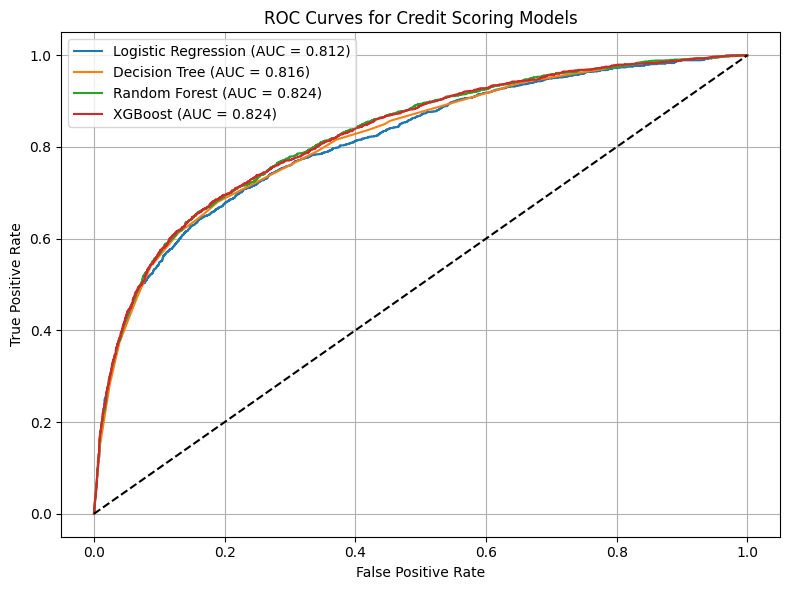

In [10]:
# Plot ROC curves

plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Credit Scoring Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


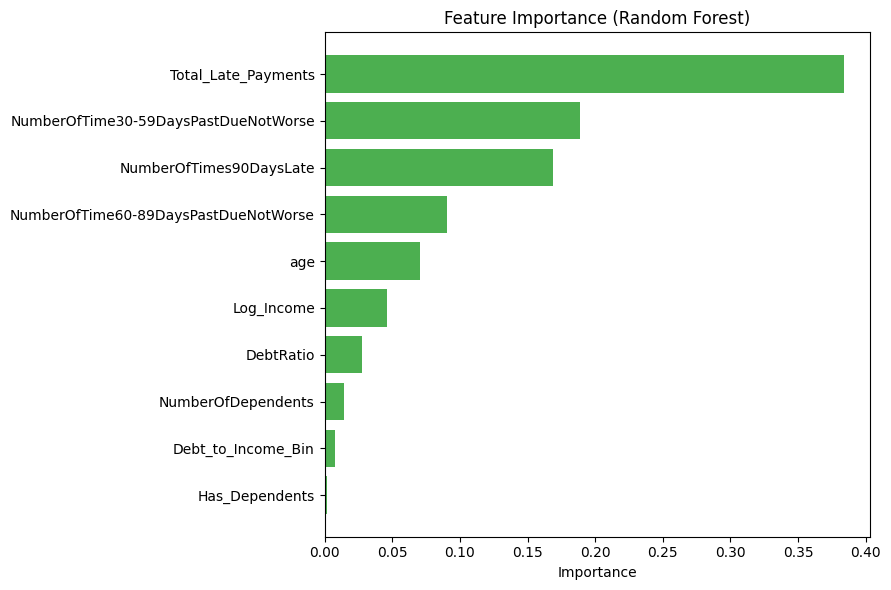

In [11]:
# Plot feature importances for Random Forest
if feature_importances is not None:
    plt.figure(figsize=(9, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='#4CAF50')
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()


<Figure size 900x600 with 0 Axes>

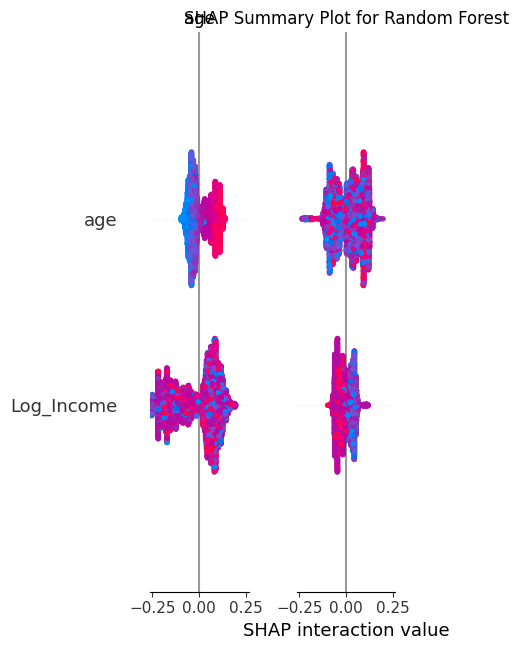

In [12]:
# SHAP summary for Random Forest

if rf_shap_values is not None and rf_shap_data is not None:
    plt.figure(figsize=(9, 6))
    # Handle SHAP return types across versions
    shap_vals_to_plot = rf_shap_values[1] if isinstance(rf_shap_values, list) else rf_shap_values
    shap.summary_plot(shap_vals_to_plot, rf_shap_data, feature_names=features, show=False)
    plt.title('SHAP Summary Plot for Random Forest')
    plt.tight_layout()
    plt.show()



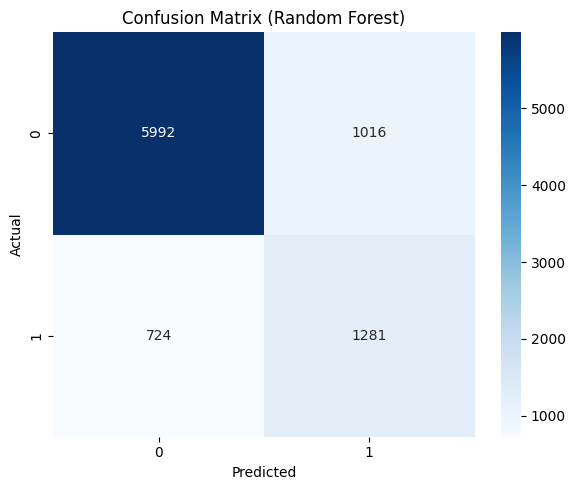

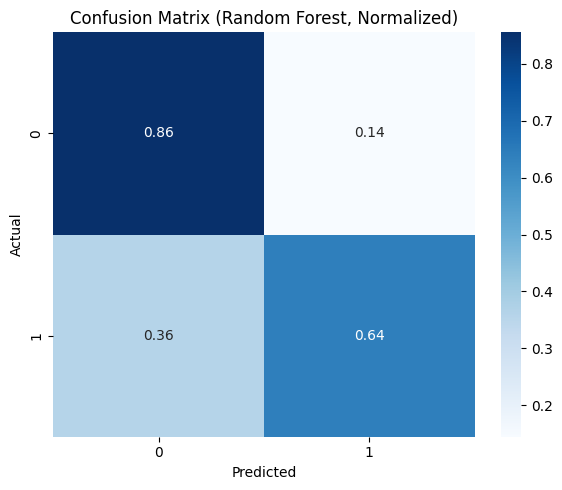

In [13]:
 # Confusion matrix for Random Forest
if 'Random Forest' in confusion_matrices:
    plot_confusion(confusion_matrices['Random Forest'], title='Confusion Matrix (Random Forest)', normalize=False)
    plot_confusion(confusion_matrices['Random Forest'], title='Confusion Matrix (Random Forest, Normalized)', normalize=True)

